In [1]:
import matplotlib.pyplot as plt

from src.utils import *
import os
import IPython.display as ipd
import logging
from src.resnet_model import SpectrogramModel
from src.SENet.SENet_model import se_resnet34_custom
import torch.nn as nn
import librosa


logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

In [2]:
config_path = '../config/residualnet_train_config.yaml'
config_res = read_yaml(config_path)
seed_everything(1234)
set_gpu(-1)
plt.style.use('dark_background')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU selected: 1 - Quadro P6000


In [3]:
win_length = 2048
n_fft = 2048
hop_length = 512
window = 'hann'

In [4]:
# load one file
file_number = 1611480
label = np.array([1])
path_to_original = f'/nas/public/dataset/asvspoof2019/LA/ASVspoof2019_LA_eval/flac/LA_E_{file_number}.flac'
clean_audio, _ = librosa.load(path_to_original, sr=16000)
print('Original Audio Length: ', len(clean_audio))
clean_audio = clean_audio[:47104]  #so that we get the exact length to be fed the model with
print('New Audio Length: ', len(clean_audio))

Original Audio Length:  69107
New Audio Length:  47104


In [5]:
ipd.Audio(clean_audio, rate=16000)

## CLEAN original audio

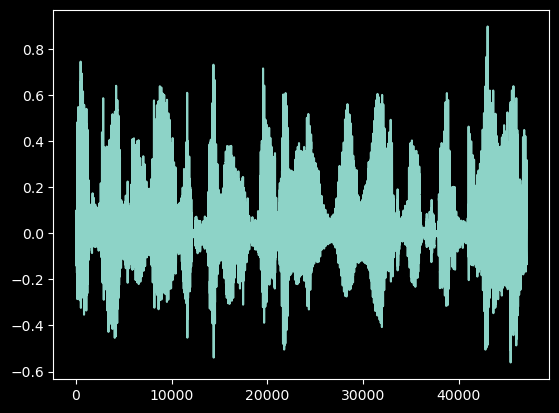

In [6]:
plt.figure()
plt.plot(clean_audio)
plt.show()

In [7]:
s = librosa.stft(clean_audio, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)
phase = np.angle(s)
mag = np.abs(s)

a = np.abs(s) ** 2
pow_spec = librosa.power_to_db(a, ref=np.max)

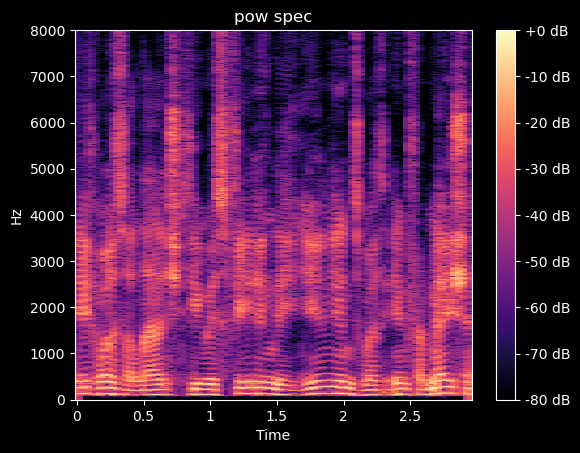

In [8]:
plt.figure()
librosa.display.specshow(pow_spec, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f'pow spec')
plt.show()

In [9]:
lin_spec = librosa.db_to_power(pow_spec)
mag_a = np.sqrt(lin_spec)

recon_a = librosa.istft(mag_a * np.exp(1j * phase), n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)  
#recon_a = librosa.util.normalize(recon_a)

## PERTURBED reconstructed audio

In [10]:
ipd.Audio(recon_a, rate=16000)

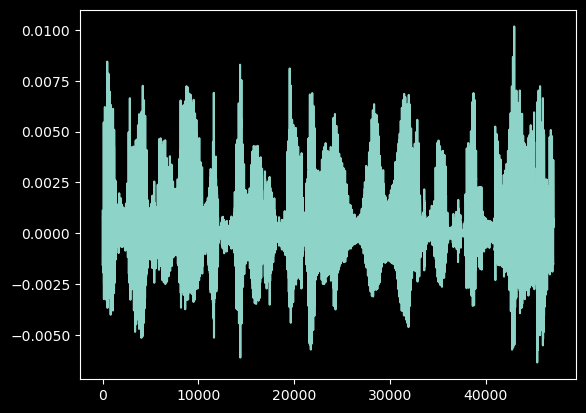

In [11]:
plt.figure()
plt.plot(recon_a)
plt.show()

In [12]:
s_ = librosa.stft(recon_a, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)
phase = np.angle(s)
mag = np.abs(s)

a_ = np.abs(s_) ** 2
pow_spec_ = librosa.power_to_db(a_, ref=np.max)

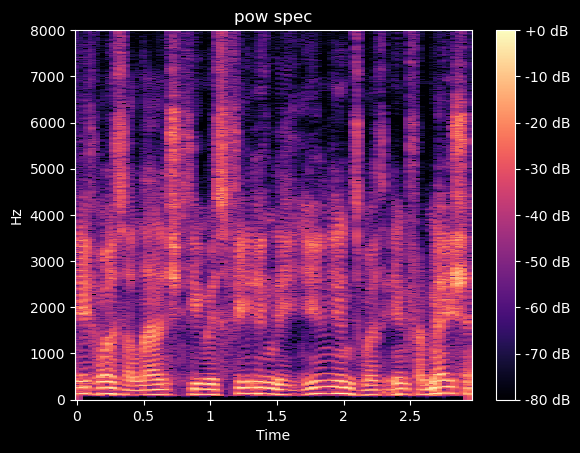

In [13]:
plt.figure()
librosa.display.specshow(pow_spec_, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f'pow spec')
plt.show()

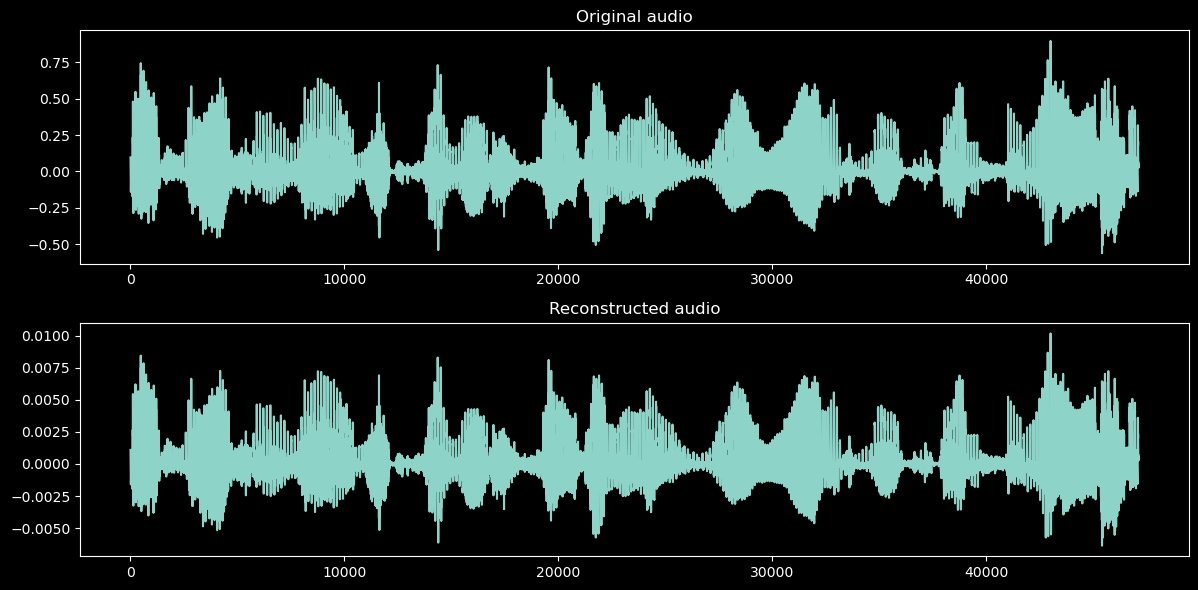

In [14]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.plot(clean_audio)
plt.title('Original audio')
plt.subplot(2,1,2)
plt.plot(recon_a)
plt.title('Reconstructed audio')
plt.tight_layout()
plt.show()

In [15]:
spec_error = np.sum(np.abs(pow_spec_-pow_spec))
print(f'{spec_error:.2f}')

1834.31


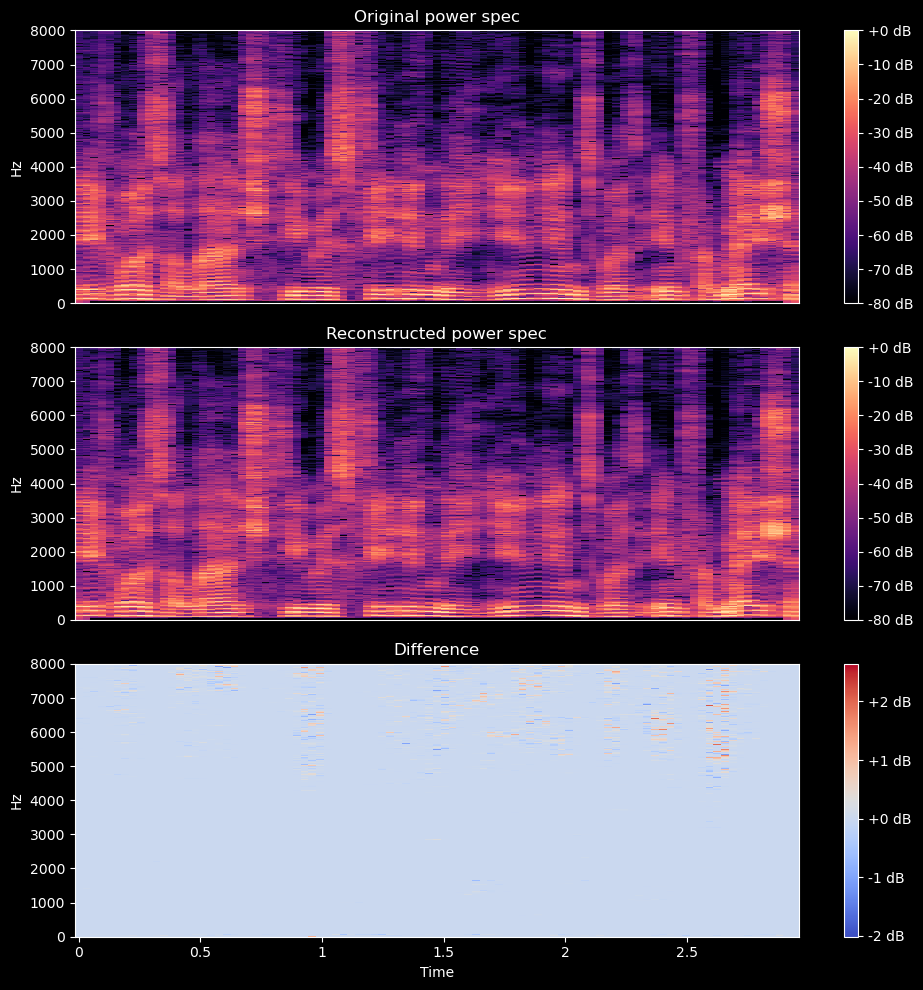

In [16]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
librosa.display.specshow(pow_spec, sr=16000,  y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Original power spec')
plt.subplot(3,1,2)
librosa.display.specshow(pow_spec_, sr=16000,  y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Reconstructed power spec')
plt.subplot(3,1,3)
librosa.display.specshow(pow_spec_-pow_spec, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')    
plt.title(f'Difference')
plt.tight_layout()
plt.show()